# Destin AI, Machine Learning Assignment 2


## Problem statement

One of the goals of our company among others is to provide users with answers to their questions. Since we are a legal startup, specially focused on immigration and visa, we are interested in helping people with their visa related questions. There are tons of sources on internet like cic, canadavisa and etc. where you can find answers to these kind of questions. But wouldn't it be great if you could just ask them in one unified platform by just chatting with an agent who is not only able to answer your questions, but also can make suggestions based on them, point you in the right direction and connect you with people like lawyers who can help you in your journey to a new country? So, that is why we are building this AI chatbot solution trained with an immigration/visa domain that can offer answers to people's questions and guide them in the right path to a destination. 


## Approach

In order to build this chatbot solution, we are leveraging already existing tools and technologies such as messenger platforms and AI agents such as Dialogflow. These agents are able to handle basic conversations and certain domains. We need to extend this domain to immigration/visa and this means we have to be able to match user question with an answer. In other words, we have to train a model which can recognize similar sentences. So, it is a Natural Language Understanding problem and we need to encode and decode sentences in some fashion to find semantically related sentences. One approach to doing this is to map sentences that share semantic and syntactic properties to similar vector representations. There is a model called Skip Thoughts (by Ryan Kiros, Yukun Zhu, Ruslan Salakhutdinov, Richard S. Zemel, Antonio Torralba, Raquel Urtasun, Sanja Fidler) which is distributed sentence encoder based on this approach. This model has been trained with a vast amount of text from wiki pages, but it also provides a mechanism for a simple vocabulary expansion which is what we need to extend our domain with visa related concepts and this is done by encoding words into vectors which is called word2vec (by Mikolov et al.)

Word2vec is computationally-efficient predictive model for learning word embeddings from raw text. It uses either of 2 approaches - Continuous Bag-of-Words model (CBOW) and the Skip-Gram model. Algorithmically, these models are similar, except that CBOW predicts target words from source context words, while the skip-gram does the inverse and predicts source context-words from the target words. Word2Vec is trained using 3 layer neural network (1 input, 1 hidden, 1 output) and actually hidden layer produces the word embeddings so we discard the ouput layer. Here in this assignment, I would like to prototype this model by training it on sentences collected from https://www.canadavisa.com/canada-immigration-questions-faq.html.  

In [32]:
# Normalize text 
import re
def normalize_text(text):

    text = text.lower()
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(canadavisa\.com/[^\s]+))','', text)
    text = re.sub('@[^\s]+','', text)
    text = re.sub('#([^\s]+)', '', text)
    text = re.sub('[:;>?<=*+()&,\-#!$%\{˜|\}\[^_\\@\]1234567890’‘]',' ', text)
    text = re.sub('[\d]','', text)
    text = text.replace(".", '')
    text = text.replace("'", '')
    text = text.replace("`", '')
    text = text.replace("'s", '')
    text = text.replace("/", ' ')
    text = text.replace("\"", ' ')
    text = text.replace("\\", '')
    text = re.sub(' +', ' ', text)
    text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    text = text.replace()
    # normalize some utf8 encoding
    text = text.replace("\x9d",'').replace("\x8c",'')
    text = text.replace("\xa0",'')
    text = text.replace("\x9d\x92", '').replace("\x9a\xaa\xf0\x9f\x94\xb5", '').replace("\xf0\x9f\x91\x8d\x87\xba\xf0\x9f\x87\xb8", '').replace("\x9f",'').replace("\x91\x8d",'')
    text = text.replace("\xf0\x9f\x87\xba\xf0\x9f\x87\xb8",'').replace("\xf0",'').replace('\xf0x9f','').replace("\x9f\x91\x8d",'').replace("\x87\xba\x87\xb8",'')
    text = text.replace("\xe2\x80\x94",'').replace("\x9d\xa4",'').replace("\x96\x91",'').replace("\xe1\x91\xac\xc9\x8c\xce\x90\xc8\xbb\xef\xbb\x89\xd4\xbc\xef\xbb\x89\xc5\xa0\xc5\xa0\xc2\xb8",'')
    text = text.replace("\xe2\x80\x99s", "").replace("\xe2\x80\x98", '').replace("\xe2\x80\x99", '').replace("\xe2\x80\x9c", "").replace("\xe2\x80\x9d", "")
    text = text.replace("\xe2\x82\xac", "").replace("\xc2\xa3", "").replace("\xc2\xa0", "").replace("\xc2\xab", "").replace("\xf0\x9f\x94\xb4", "").replace("\xf0\x9f\x87\xba\xf0\x9f\x87\xb8\xf0\x9f", "")
    
    text = re.sub(r"\b[a-z]\b", "", text)
    text = re.sub( '\s+', ' ', text).strip()
    text = re.sub(r'\.+', ".", text)
    text = re.sub(r'\.\.+', ' ', text).replace('.', '')
    
    # Replace multiple dots with space
    text = re.sub('\.\.+', ' ', text) 
    
    # Remove single dots
    text = re.sub('\.', '', text)
    text = re.sub(r'\.{2,}', ' ', text)
    text = re.sub(r'\.{1}', '', text)
    
    return text

### Text preparation

Here we read the input file which contains FAQ content scraped from https://www.canadavisa.com/canada-immigration-questions-faq.html.

In [37]:
# Read input text
f = open('faq.txt')
content = f.read()
print(content)


		Frequently asked questions about the Express Entry immigration selection system.





        +
        -
        1. What is Express Entry?






         Express Entry is an electronic management application system for immigration to Canada.
It is not an immigration program. Rather, it facilitates the selection and processing of Canada’s economic immigration programs:

the Federal Skilled Worker Class (formerly the Federal Skilled Worker Program),
the Federal Skilled Trades Class (formerly the Federal Skilled Trades Program), 
the Canadian Experience Class, and
a portion of the Provincial Nominee Programs. 

Applicants make an "expression of interest" (EOI) in immigrating to Canada and, if they are eligible for at least one of the aforementioned programs, they then enter the Express Entry pool. The federal government and provincial governments, as well as Canadian employers, are then able to select candidates from this pool who will then receive an Invitation To Apply (ITA) for imm

As we can see from the output, this data is very messy with extra characters, spaces and etc. that we need to clean for our training. This process is called text normalization. Let's do the normalization using our helper function defined above.

In [38]:
# Normalize content
content = normalize_text(content)
print(content)

frequently asked questions about the express entry immigration selection system what is express entry express entryis an electronic management application system for immigration to canada it is not an immigration program rather it facilitates the selection and processing of canada economic immigration programs the federal skilled worker class formerly the federal skilled worker program the federal skilled trades class formerly the federal skilled trades program the canadian experience class and portion of the provincial nominee programs applicants make an expression of interest eoi in immigrating to canada and if they are eligible for at least one of the aforementioned programs they then enter the express entry pool the federal government and provincial governments as well as canadian employers are then able to select candidates from this pool who will then receive an invitation to apply ita for immigration tocanada under one of the programs express entry moves canada from first come f

### Tokenization

Now we need to tokenize this content into words so that we can operate word-wise and discover interesting properties about this text. Let's see what are the 10 most common words in our text.

In [39]:
import collections

# Tokenize content
words = content.split()
counts = collections.Counter(words).most_common() 
print ("Word count", counts[:10])

Word count [('the', 3983), ('to', 2539), ('in', 2353), ('of', 2008), ('and', 1930), ('for', 1440), ('or', 1168), ('is', 1162), ('canada', 1100), ('are', 796)]


Now let's build a dictionary of unique words and print its size.

In [48]:
# Build dictionary
unique_words =  [c[0] for c in counts]
dictionary = {w: i for i, w in enumerate(unique_words)}
dict_size = len(dictionary)
print(dict_size)

4692


### Data preparation

The next step is to make data out of word indices. We will use this new data to prepare our special training data.

In [41]:
# Make data of word indices
data = [dictionary[word] for word in words]
print('Sample data', data[:10], words[:10])

Sample data [242, 227, 198, 66, 0, 42, 34, 18, 193, 83] ['frequently', 'asked', 'questions', 'about', 'the', 'express', 'entry', 'immigration', 'selection', 'system']


Now we need to prepare our actual training data using Continuous Bag of Words (CBOW) and Skip-Gram models.

In [43]:
# Build CBOW pairs of indices and words
cbow_pairs = []

for i in range(1, len(data)-1) :
    cbow_pairs.append([[data[i-1], data[i+1]], data[i]])
    
print('CBOW pairs: ', cbow_pairs[:5])
print()

cbow_pairs_words = []

for i in range(1, len(words)-1) :
    cbow_pairs_words.append([[words[i-1], words[i+1]], words[i]])
    
print('CBOW pair words: ', cbow_pairs_words[:5])

CBOW pairs:  [[[242, 198], 227], [[227, 66], 198], [[198, 0], 66], [[66, 42], 0], [[0, 34], 42]]

CBOW pair words:  [[['frequently', 'questions'], 'asked'], [['asked', 'about'], 'questions'], [['questions', 'the'], 'about'], [['about', 'express'], 'the'], [['the', 'entry'], 'express']]


In [44]:
# Build Skip-Gram pairs of indices and words
skip_gram_pairs=[]

for c in cbow_pairs:
    skip_gram_pairs.append([c[1],c[0][0]])
    skip_gram_pairs.append([c[1],c[0][1]])

print('Skip-Gram pairs: ', skip_gram_pairs[:5])
print()

skip_gram_pairs_words=[]

for c in cbow_pairs_words:
    skip_gram_pairs_words.append([c[1],c[0][0]])
    skip_gram_pairs_words.append([c[1],c[0][1]])
    
print('Skip-Gram pair words: ', skip_gram_pairs_words[:5])

Skip-Gram pairs:  [[227, 242], [227, 198], [198, 227], [198, 66], [66, 198]]

Skip-Gram pair words:  [['asked', 'frequently'], ['asked', 'questions'], ['questions', 'asked'], ['questions', 'about'], ['about', 'questions']]


Here we define a helper function to get sample batches from our dataset which we will use in our training algorithm.

In [47]:
# Generate a batch
import numpy as np

def get_batch(size):
    assert size<len(skip_gram_pairs)
    X=[]
    Y=[]
    samples = np.random.choice(range(len(skip_gram_pairs)),size,replace=False)
    
    for s in samples:
        X.append(skip_gram_pairs[s][0])
        Y.append([skip_gram_pairs[s][1]])
    return X , Y

# sample batch generation for size of 5
print ('Batches (x, y)', get_batch(5))

Batches (x, y) ([1028, 172, 93, 38, 6], [[738], [1], [4], [97], [385]])


### Model training

Now we are going to define the training algorithm and its parameters and then run it to get our model. Here we are using the NCE loss as a loss function and Gradient descent for minimizing. 

In [49]:
# Setup the training algorithm
import tensorflow as tf

batch_size = 20
embedding_size = 2
num_sampled = 15    # Number of negative examples to sample.

X = tf.placeholder(tf.int32,shape=[batch_size]) # inputs
Y = tf.placeholder(tf.int32,shape=[batch_size,1]) # labels

with tf.device("/cpu:0"):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(tf.random_uniform([dict_size, embedding_size],-1.0,1.0))
    embed = tf.nn.embedding_lookup(embeddings, X) # lookup table
    
# Construct the variables for the NCE loss
nce_weights = tf.Variable(tf.random_uniform([dict_size, embedding_size],-1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([dict_size]))

# Compute the average NCE loss for the batch.
# This does the magic:
#   tf.nn.nce_loss(weights, biases, inputs, labels, num_sampled, num_classes ...)
# It automatically draws negative samples when we evaluate the loss.
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases, Y, embed, num_sampled, dict_size))

# Use the Gradient Descent optimizer
optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

#### Warning
This next cell will take about 3-4 mins.

In [50]:
# Train it
epochs = 10000
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        
        batch_inputs, batch_labels = get_batch(batch_size)
        _,loss_val=sess.run([optimizer,loss],feed_dict = {X : batch_inputs, Y : batch_labels })
        
        if epoch % 1000 == 0:
            print("Loss at ", epoch, loss_val) # Report the loss
    
    trained_embeddings = embeddings.eval()

Loss at  0 58.434326
Loss at  1000 8.516962
Loss at  2000 11.783349
Loss at  3000 5.4711213
Loss at  4000 4.733712
Loss at  5000 3.5086732
Loss at  6000 3.9627311
Loss at  7000 4.311698
Loss at  8000 3.5144622
Loss at  9000 4.2217636


Now we have our embeddings for words, let's try to visualize it by making graph of words and their respective vectors. This shows us that words that are related map to similar vectors. 

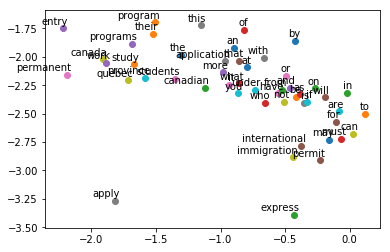

In [51]:
import matplotlib.pyplot as plt
if trained_embeddings.shape[1] == 2:
    labels = unique_words[:50]
    for i, label in enumerate(labels):
        x, y = trained_embeddings[i,:]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2),
            textcoords='offset points', ha='right', va='bottom')
    plt.show()